# Ciudadano Distrito

In [8]:
import time
import subprocess
import math
                                                                                                                                    
from tqdm.notebook import tqdm

import pandas as pd
import geopandas as gpd
from keplergl import KeplerGl
import psycopg2 as psql
from sqlalchemy import create_engine
from functools import partial
import matplotlib.pyplot as plt

from networkx import is_connected, connected_components
from gerrychain import (
    Graph, updaters, Partition, constraints, MarkovChain, accept, proposals,
    tree, random
)
import maup

In [9]:
query_postgres = True

random.random.seed(42)

province_id = '30'

province_mapper = {
    '02': 'Albacete',
    '03': 'Alicante/Alacant',
    '04': 'Almería',
    '01': 'Araba/Álava',
    '33': 'Asturias',
    '05': 'Ávila',
    '06': 'Badajoz',
    '07': 'Balears, Illes',
    '08': 'Barcelona',
    '48': 'Bizkaia',
    '09': 'Burgos',
    '10': 'Cáceres',
    '11': 'Cádiz',
    '39': 'Cantabria',
    '12': 'Castellón/Castelló',
    '13': 'Ciudad Real',
    '14': 'Córdoba',
    '15': 'Coruña, A',
    '16': 'Cuenca',
    '20': 'Gipuzkoa',
    '17': 'Girona',
    '18': 'Granada',
    '19': 'Guadalajara',
    '21': 'Huelva',
    '22': 'Huesca',
    '23': 'Jaén',
    '24': 'León',
    '25': 'Lleida',
    '27': 'Lugo',
    '28': 'Madrid',
    '29': 'Málaga',
    '30': 'Murcia',
    '31': 'Navarra',
    '32': 'Ourense',
    '34': 'Palencia',
    '35': 'Palmas, Las',
    '36': 'Pontevedra',
    '26': 'Rioja, La',
    '37': 'Salamanca',
    '38': 'Santa Cruz de Tenerife',
    '40': 'Segovia',
    '41': 'Sevilla',
    '42': 'Soria',
    '43': 'Tarragona',
    '44': 'Teruel',
    '45': 'Toledo',
    '46': 'Valencia/València',
    '47': 'Valladolid',
    '49': 'Zamora',
    '50': 'Zaragoza',
    '51': 'Ceuta',
    '52': 'Melilla'
}

In [10]:
psql_config = {
    'database': 'geoblink_gamma',
    'user': 'geoblink',
    'password': 'Geo_S4urio',
    'host': 'datanalytics',
    'port': '5441'
}

if query_postgres:
    conn = psql.connect(**psql_config)

In [11]:
query = f"""

SELECT 
    aaaf.id_area, 
    aaaf.name, 
    aaaf.pob_t_total, 
    aaaf.geometry
FROM
    aggregated_administrative_area_full AS aaaf,
    administrative_area_level AS aal
WHERE
    aaaf.id_administrative_area_level = aal.id_administrative_area_level
    AND aal.code_country = 'ESP'
    AND aal.name = 'province'
    AND LEFT(aaaf.id_area , 2) = '{province_id}';
"""

if query_postgres:
    province = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    province = gpd.read_parquet('data/province.parquet')

province.head()

,id_area,name,pob_t_total,geometry
0,30,Murcia,1493898.0,"MULTIPOLYGON (((-1.54669 37.40733, -1.54845 37..."


In [12]:
# province.to_parquet('data/province.parquet')

In [13]:
query = f"""

SELECT 
    aaaf.id_area, 
    aaaf.name, 
    aaaf.pob_t_total, 
    aaaf.geometry
FROM
    aggregated_administrative_area_full AS aaaf,
    administrative_area_level AS aal
WHERE
    aaaf.id_administrative_area_level = aal.id_administrative_area_level
    AND aal.code_country = 'ESP'
    AND aal.name = 'municipality'
    AND LEFT(aaaf.id_area , 2) = '{province_id}';
"""

if query_postgres:
    municipality = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    municipality = gpd.read_parquet('data/municipality.parquet')

municipality.head()

,id_area,name,pob_t_total,geometry
0,30902,"Alcázares, Los",16138.0,"MULTIPOLYGON (((-0.85187 37.73054, -0.85315 37..."
1,30901,Santomera,16206.0,"MULTIPOLYGON (((-1.03423 38.04692, -1.03974 38..."
2,30028,Moratalla,7839.0,"MULTIPOLYGON (((-1.85678 38.14289, -1.85922 38..."
3,30027,Molina de Segura,71890.0,"MULTIPOLYGON (((-1.17779 38.01970, -1.17918 38..."
4,30043,Yecla,34432.0,"MULTIPOLYGON (((-1.11967 38.73772, -1.11677 38..."


In [14]:
# municipality.to_parquet('data/municipality.parquet')

In [15]:
query = f"""

SELECT 
    aaaf.id_area, 
    aaaf.name, 
    aaaf.pob_t_total, 
    aaaf.geometry
FROM
    aggregated_administrative_area_full AS aaaf,
    administrative_area_level AS aal
WHERE
    aaaf.id_administrative_area_level = aal.id_administrative_area_level
    AND aal.code_country = 'ESP'
    AND aal.name = 'district'
    AND LEFT(aaaf.id_area , 2) = '{province_id}';
"""

if query_postgres:
    district = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    district = gpd.read_parquet('data/district.parquet')

district.head()

,id_area,name,pob_t_total,geometry
0,3090201,3090201,16138.0,"MULTIPOLYGON (((-0.85187 37.73054, -0.85195 37..."
1,3090101,3090101,16206.0,"MULTIPOLYGON (((-1.03423 38.04692, -1.03974 38..."
2,3004301,3004301,34432.0,"MULTIPOLYGON (((-1.11967 38.73772, -1.11950 38..."
3,3004201,3004201,2910.0,"MULTIPOLYGON (((-1.31083 38.12816, -1.31010 38..."
4,3004106,3004106,997.0,"MULTIPOLYGON (((-0.87233 37.60224, -0.84062 37..."


In [16]:
# district.to_parquet('data/district.parquet')

In [17]:
query = f"""

SELECT 
    aaaf.id_area, 
    aaaf.name, 
    aaaf.pob_t_total, 
    aaaf.geometry
FROM
    aggregated_administrative_area_full AS aaaf,
    administrative_area_level AS aal
WHERE
    aaaf.id_administrative_area_level = aal.id_administrative_area_level
    AND aal.code_country = 'ESP'
    AND aal.name = 'zip_code'
    AND LEFT(aaaf.id_area , 2) = '{province_id}';
"""

if query_postgres:
    zip_code = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    zip_code = gpd.read_parquet('data/zip_code.parquet')

zip_code.head()

,id_area,name,pob_t_total,geometry
0,30001,30001,6672.558439,"MULTIPOLYGON (((-1.12543 37.98749, -1.12644 37..."
1,30002,30002,20612.835950,"MULTIPOLYGON (((-1.12798 37.98225, -1.12794 37..."
2,30004,30004,8536.843875,"MULTIPOLYGON (((-1.13204 37.98721, -1.13192 37..."
3,30003,30003,11593.958973,"MULTIPOLYGON (((-1.12372 37.98900, -1.12363 37..."
4,30008,30008,13816.797284,"MULTIPOLYGON (((-1.13190 37.99662, -1.13178 37..."


In [18]:
# zip_code.to_parquet('data/zip_code.parquet')

In [19]:
query = f"""

SELECT 
    aaaf.id_area, 
    aaaf.name, 
    aaaf.pob_t_total, 
    aaaf.geometry
FROM
    aggregated_administrative_area_full AS aaaf,
    administrative_area_level AS aal
WHERE
    aaaf.id_administrative_area_level = aal.id_administrative_area_level
    AND aal.code_country = 'ESP'
    AND aal.name = 'census_section'
    AND LEFT(aaaf.id_area , 2) = '{province_id}';
"""


if query_postgres:
    census_section = gpd.GeoDataFrame.from_postgis(query, conn, geom_col='geometry')
else:
    census_section = gpd.read_parquet('data/census_section.parquet')
    
census_section.head()

,id_area,name,pob_t_total,geometry
0,3090101002,3090101002,1528.0,"MULTIPOLYGON (((-1.04729 38.06279, -1.04704 38..."
1,3003401001,3003401001,1264.0,"MULTIPOLYGON (((-1.46975 38.19402, -1.46960 38..."
2,3003003045,3003003045,855.0,"MULTIPOLYGON (((-1.12760 37.97707, -1.12758 37..."
3,3001501020,3001501020,1142.0,"MULTIPOLYGON (((-1.85853 38.10228, -1.85954 38..."
4,3090101008,3090101008,1052.0,"MULTIPOLYGON (((-1.04986 38.06294, -1.05229 38..."


In [20]:
# census_section.to_parquet('data/census_section.parquet')

## Find optimal aggregation

In [43]:
# Obtain province codes
province['province_id'] = province['id_area']
province_ids = province['province_id'].tolist()

municipality['province_id'] = municipality['id_area'].str[:2]
# municipality['latitude'] = municipality['geometry'].centroid.y
# municipality['longitude'] = municipality['geometry'].centroid.x

district['province_id'] = district['id_area'].str[:2]
# district['latitude'] = district['geometry'].centroid.y
# district['longitude'] = district['geometry'].centroid.x

zip_code['province_id'] = zip_code['id_area'].str[:2]
# zip_code['latitude'] = zip_code['geometry'].centroid.y
# zip_code['longitude'] = zip_code['geometry'].centroid.x

census_section['province_id'] = census_section['id_area'].str[:2]
census_section['municipality_id'] = census_section['id_area'].str[:5]
# census_section['latitude'] = census_section['geometry'].centroid.y
# census_section['longitude'] = census_section['geometry'].centroid.x

In [44]:
query = f"province_id == '{province_id}'"

In [45]:
province_cp = province.query(query).copy()
municipality_cp = municipality.query(query).copy()
district_cp = district.query(query).copy()
zip_code_cp = zip_code.query(query).copy()
census_section_cp = census_section.query(query).copy()

geo_data = {
    'province': province_cp, 
    'municipality': municipality_cp,
    'district': district_cp,
    'zip_code': zip_code_cp,
    'census_section': census_section_cp
}

KeplerGl(height=800, width=1000).save_to_html(geo_data, file_name='province.html', center_map=True)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to province.html!


In [46]:
target = 33000
variable = "pob_t_total"
node_repeats = 1

In [47]:
print(census_section.shape)
census_section.head()

(1226, 6)


,id_area,name,pob_t_total,geometry,province_id,municipality_id
0,3090101002,3090101002,1528.0,"MULTIPOLYGON (((-1.04729 38.06279, -1.04704 38...",30,30901
1,3003401001,3003401001,1264.0,"MULTIPOLYGON (((-1.46975 38.19402, -1.46960 38...",30,30034
2,3003003045,3003003045,855.0,"MULTIPOLYGON (((-1.12760 37.97707, -1.12758 37...",30,30030
3,3001501020,3001501020,1142.0,"MULTIPOLYGON (((-1.85853 38.10228, -1.85954 38...",30,30015
4,3090101008,3090101008,1052.0,"MULTIPOLYGON (((-1.04986 38.06294, -1.05229 38...",30,30901


In [48]:
municipality_agg = census_section.dissolve(by='municipality_id', aggfunc='sum').reset_index()
print(municipality_agg.shape)
municipality_agg.head()

(45, 3)


,municipality_id,geometry,pob_t_total
0,30001,"POLYGON ((-0.99167 38.19615, -0.99169 38.19614...",6127.0
1,30002,"POLYGON ((-1.41131 38.21379, -1.40832 38.21330...",12964.0
2,30003,"MULTIPOLYGON (((-1.59163 37.40163, -1.59185 37...",35301.0
3,30004,"POLYGON ((-1.35931 38.03755, -1.35908 38.03741...",1373.0
4,30005,"POLYGON ((-1.20478 37.95938, -1.20457 37.95891...",42048.0


In [49]:
mask = municipality_agg[variable] < target

gdf_area = municipality_agg[mask].copy()

# Feature eng for concat
gdf_area = gdf_area.rename(columns = {'municipality_id': 'id_area'})
gdf_area.head()

,id_area,geometry,pob_t_total
0,30001,"POLYGON ((-0.99167 38.19615, -0.99169 38.19614...",6127.0
1,30002,"POLYGON ((-1.41131 38.21379, -1.40832 38.21330...",12964.0
3,30004,"POLYGON ((-1.35931 38.03755, -1.35908 38.03741...",1373.0
5,30006,"POLYGON ((-1.65895 37.75374, -1.65977 37.75476...",1022.0
6,30007,"POLYGON ((-1.23375 38.05056, -1.23218 38.04928...",9638.0


In [50]:
# Municipalities with more than target population
filtered_out = municipality_agg[~mask].copy()
filtered_out.head()

,municipality_id,geometry,pob_t_total
2,30003,"MULTIPOLYGON (((-1.59163 37.40163, -1.59185 37...",35301.0
4,30005,"POLYGON ((-1.20478 37.95938, -1.20457 37.95891...",42048.0
15,30016,"POLYGON ((-0.87201 37.58752, -0.87199 37.58598...",214802.0
18,30019,"POLYGON ((-1.31888 38.31345, -1.31893 38.31329...",34988.0
23,30024,"POLYGON ((-1.64745 37.52725, -1.64766 37.52683...",94404.0


<AxesSubplot:>

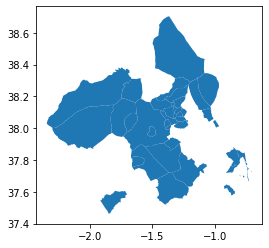

In [51]:
gdf_area.plot()

<AxesSubplot:>

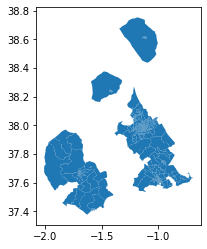

In [52]:
filtered_census_section = filtered_out['municipality_id'].tolist()
difference = census_section[census_section['municipality_id'].isin(filtered_census_section)]

# Feature eng for concat
difference = difference.drop(['name', 'province_id', 'municipality_id'], axis=1)

# Filter out from zip_code
#Graph.from_geodataframe(difference)
difference.plot()

(875, 3)


<AxesSubplot:>

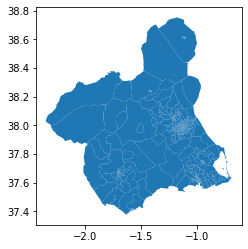

In [53]:
cols = difference.columns

gdf = gpd.GeoDataFrame(pd.concat([gdf_area[cols], difference], ignore_index=True))
print(gdf.shape)
gdf.plot()

In [54]:
gdf.head()

,id_area,pob_t_total,geometry
0,30001,6127.0,"POLYGON ((-0.99167 38.19615, -0.99169 38.19614..."
1,30002,12964.0,"POLYGON ((-1.41131 38.21379, -1.40832 38.21330..."
2,30004,1373.0,"POLYGON ((-1.35931 38.03755, -1.35908 38.03741..."
3,30006,1022.0,"POLYGON ((-1.65895 37.75374, -1.65977 37.75476..."
4,30007,9638.0,"POLYGON ((-1.23375 38.05056, -1.23218 38.04928..."


In [55]:
gdf.tail()

,id_area,pob_t_total,geometry
870,3003002031,1157.0,"MULTIPOLYGON (((-1.12943 37.98668, -1.12943 37..."
871,3002401027,1390.0,"MULTIPOLYGON (((-1.68533 37.68071, -1.68535 37..."
872,3003001049,967.0,"MULTIPOLYGON (((-1.14468 38.00633, -1.14468 38..."
873,3001609004,1286.0,"MULTIPOLYGON (((-1.04362 37.62911, -1.04359 37..."
874,3002401044,1546.0,"MULTIPOLYGON (((-1.68422 37.68262, -1.68408 37..."


In [56]:
graph = Graph.from_geodataframe(gdf)
graph.add_data(gdf)

/home/iplaton/myprojects/diputado-distrito/.venv/lib/python3.6/site-packages/gerrychain/graph/graph.py:152: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [57]:
myupdaters = {
    "population": updaters.Tally(variable, alias="population"),
    "cut_edges": updaters.cut_edges,
}

45.26963636363636


<AxesSubplot:>

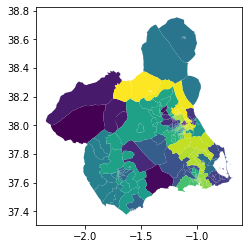

In [58]:
total_population = sum([graph.nodes[n][variable] for n in graph.nodes])
districts = total_population / target
print(districts)

assignment = tree.recursive_tree_part(
    graph, 
    range(int(round(districts))),
    target, #ideal population for a district
    variable,
    0.285
)

#make a GerryChain Partition object
initial_partition = Partition(graph, assignment, myupdaters)
initial_partition.plot(gdf) #you have to hand it gdf, the geodataframe for the graph

In [60]:
mapper = {graph.nodes[node]['id_area']: node for node in graph.nodes}
gdf['district'] = gdf['id_area'].apply(lambda x: assignment.get(mapper.get(x)))
display(gdf.groupby('district')[variable].sum().describe())
gdf.head()

count       45.000000
mean     33197.733333
std       5201.208902
min      23977.000000
25%      30302.000000
50%      33337.000000
75%      36264.000000
max      45166.000000
Name: pob_t_total, dtype: float64

,id_area,pob_t_total,geometry,district
0,30001,6127.0,"POLYGON ((-0.99167 38.19615, -0.99169 38.19614...",18
1,30002,12964.0,"POLYGON ((-1.41131 38.21379, -1.40832 38.21330...",43
2,30004,1373.0,"POLYGON ((-1.35931 38.03755, -1.35908 38.03741...",25
3,30006,1022.0,"POLYGON ((-1.65895 37.75374, -1.65977 37.75476...",25
4,30007,9638.0,"POLYGON ((-1.23375 38.05056, -1.23218 38.04928...",6


In [61]:
gdf.shape

(875, 4)

In [62]:
districts = gdf.dissolve(by='district', aggfunc='sum').reset_index().copy()

In [63]:
kepler = KeplerGl(height=800, width=1000)

municipality_agg_cp = municipality_agg.copy()
kepler.add_data(data=municipality_agg_cp, name='municipality')

districts_cp = districts.copy()
kepler.add_data(data=districts_cp, name='district')

gdf_cp = gdf.copy()
kepler.add_data(data=gdf_cp, name='municipalites-censussection')


kepler

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'municipality': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [64]:
#no need for contiguity since that is forced by the proposal
myconstraints = [
    constraints.contiguous, #fast contiguity tracker only for flip walks
    constraints.within_percent_of_ideal_population(initial_partition, 0.5) #population deviation
]

#little python trick to fix some parameters in the proposal function
myproposal = partial(
    proposals.recom,
    pop_col=variable,
    pop_target=target,
    epsilon=0.2, #population tolerance
    node_repeats=2 #parameter for spanning tree method, set to 2 is fine
)

In [65]:

# Configure the MarkovChain.
chain = MarkovChain(
    proposal=myproposal,
    constraints=myconstraints,
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=100
)

In [66]:
for i, step in enumerate(chain):
    print(i, end=" ")
    gdf['flipstep{}'.format(i)] = [step.assignment[n] for n in graph.nodes] #store plan

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [67]:
gdf.head()

,id_area,pob_t_total,geometry,district,flipstep0,flipstep1,flipstep2,flipstep3,flipstep4,flipstep5,...,flipstep90,flipstep91,flipstep92,flipstep93,flipstep94,flipstep95,flipstep96,flipstep97,flipstep98,flipstep99
0,30001,6127.0,"POLYGON ((-0.99167 38.19615, -0.99169 38.19614...",18,18,18,18,18,18,43,...,18,18,18,18,18,18,18,18,18,18
1,30002,12964.0,"POLYGON ((-1.41131 38.21379, -1.40832 38.21330...",43,43,43,43,43,43,18,...,43,43,43,43,43,43,43,43,43,43
2,30004,1373.0,"POLYGON ((-1.35931 38.03755, -1.35908 38.03741...",25,25,25,25,25,25,25,...,4,4,4,4,4,25,25,25,25,25
3,30006,1022.0,"POLYGON ((-1.65895 37.75374, -1.65977 37.75476...",25,25,25,25,25,25,25,...,15,15,15,25,25,4,4,4,4,4
4,30007,9638.0,"POLYGON ((-1.23375 38.05056, -1.23218 38.04928...",6,6,6,6,6,6,6,...,3,3,30,30,30,30,30,30,30,30


In [76]:
number = 90
column = f'flipstep{number}'

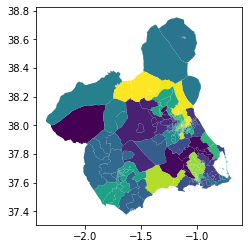

In [77]:
gdf.plot(column=column.format(number))
plt.show()

In [78]:
gdf.head()

,id_area,pob_t_total,geometry,district,flipstep0,flipstep1,flipstep2,flipstep3,flipstep4,flipstep5,...,flipstep90,flipstep91,flipstep92,flipstep93,flipstep94,flipstep95,flipstep96,flipstep97,flipstep98,flipstep99
0,30001,6127.0,"POLYGON ((-0.99167 38.19615, -0.99169 38.19614...",18,18,18,18,18,18,43,...,18,18,18,18,18,18,18,18,18,18
1,30002,12964.0,"POLYGON ((-1.41131 38.21379, -1.40832 38.21330...",43,43,43,43,43,43,18,...,43,43,43,43,43,43,43,43,43,43
2,30004,1373.0,"POLYGON ((-1.35931 38.03755, -1.35908 38.03741...",25,25,25,25,25,25,25,...,4,4,4,4,4,25,25,25,25,25
3,30006,1022.0,"POLYGON ((-1.65895 37.75374, -1.65977 37.75476...",25,25,25,25,25,25,25,...,15,15,15,25,25,4,4,4,4,4
4,30007,9638.0,"POLYGON ((-1.23375 38.05056, -1.23218 38.04928...",6,6,6,6,6,6,6,...,3,3,30,30,30,30,30,30,30,30


In [79]:
# gdf['geometry'] = gdf['geometry'].buffer(0.0001)
districts = gdf.dissolve(by=column, aggfunc='sum').reset_index().copy()
districts.head()

,flipstep90,geometry,pob_t_total,district,flipstep0,flipstep1,flipstep2,flipstep3,flipstep4,flipstep5,...,flipstep89,flipstep91,flipstep92,flipstep93,flipstep94,flipstep95,flipstep96,flipstep97,flipstep98,flipstep99
0,0,"POLYGON ((-1.88865 37.93124, -1.89009 37.93000...",25760.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,"POLYGON ((-1.04899 37.66258, -1.04881 37.66251...",37978.0,398,398,398,398,398,362,362,...,13,13,13,13,13,13,13,13,13,13
2,2,"POLYGON ((-1.27255 38.07356, -1.27558 38.07424...",31088.0,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
3,3,"POLYGON ((-1.20382 38.04449, -1.20322 38.04414...",27739.0,426,426,426,426,426,426,426,...,45,45,288,288,288,288,288,288,288,288
4,4,"POLYGON ((-1.36093 37.99521, -1.36093 37.99521...",25395.0,125,125,125,125,125,125,125,...,20,20,20,20,20,125,125,125,125,125


In [ ]:
districts_cp.to_json('')

In [80]:
kepler = KeplerGl(height=800, width=1000)

districts_cp = districts.copy()
kepler.add_data(data=districts_cp, name='districts')

gdf_cp = gdf.copy()
kepler.add_data(data=gdf_cp, name='municipalites-censussection')

kepler

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'districts': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…

In [81]:
province_cp = province.copy()
municipality_cp = municipality.copy()
districts_cp = districts.copy()
zip_code_cp = zip_code.copy()
census_section_cp = census_section.copy()

geo_data = {
    'province': province_cp, 
    'municipality': municipality_cp,
    'districts': districts_cp,
    'zip_code': zip_code_cp,
    'census_section': census_section_cp
}

KeplerGl(height=800, width=1000).save_to_html(geo_data, file_name='districts.html', center_map=True)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to districts.html!


In [82]:
districts.to_file('districts.json', driver='GeoJSON')